In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
students = pd.read_csv('Pirelli_data_challenge_v2.csv')

In [3]:
students.shape

(384, 358)

In [8]:
students.isna().sum().sum() #non sembrano esserci missing data

0

In [4]:
students.head() #tutte le colonne sembrano essere buleane

,question_0,question_1,question_2,question_3,question_4,question_5,question_6,question_7,question_8,question_9,...,question_348,question_349,question_350,question_351,question_352,question_353,question_354,question_355,question_356,score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.296901
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057026
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.916191
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075314
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.290505


/Users/gmisser/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

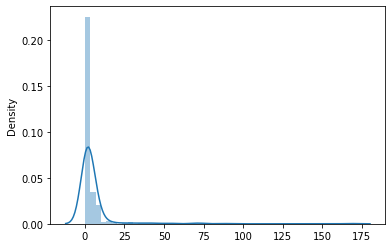

In [5]:
sns.distplot(students.sum()) #distribuzione numero di 1 per domanda, ho la gran parte delle domande dove tutti danno 0 

In [6]:
(students.sum()==0).sum() # addirittura 5 domande a cui tutti danno 0

5

In [7]:
# plotto in 2d il backgroud degli studenti per capire come si distribuiscono

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
components_2_noscore = pca.fit_transform(students.iloc[:,:-1])
pcaDF = pd.DataFrame(data = components_2_noscore, columns = ['pc_1', 'pc_2'])
pcaDF['score'] = students['score']

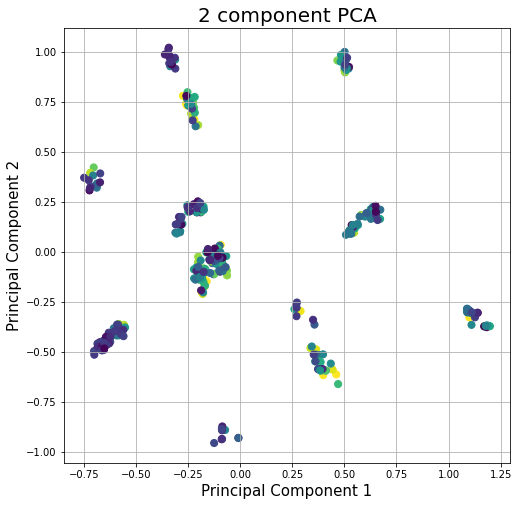

In [9]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

ax.scatter(pcaDF['pc_1'], pcaDF['pc_2'], c = pcaDF['score'], s = 50)
ax.grid()

In [10]:
## pare si distribuiscano abbastanza equamente nello spazio, sembra convergano in cluster, da analizzare piu' a fondo

/Users/gmisser/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='score'>

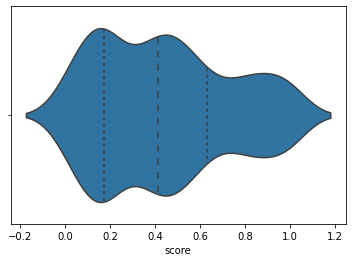

In [11]:
sns.violinplot(students['score'], inner='quartile') #distribuzione della performance allo skill test, distribuzione quasi uniforme

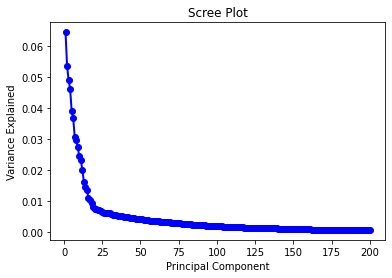

In [12]:
# dato che ho molte features rispetto al numero di osservazioni puo' essere una buona idea vedere se c'e' spazio per dimensionality reduction, potremmo ridurre il numero di colonne senza perdere molto in termini informativi

import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components=200)
components_200_noscore = pca.fit_transform(students.iloc[:,:-1])

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')


plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [13]:
(pca.explained_variance_ratio_[:20]).sum()
# la varianza spiegata dalle prime 20 componenti principali non e' strabiliante
# ma vista la grande riduzione percentuale, il chiaro gomito nello scree plot
# ed il mio attuale obiettivo (punto a creare dei cluster per aiutarmi nella distribuzioone degli studenti nelle classi),
# mi accontento di questo 53.5%

0.5351510017065148

In [14]:
components_20_noscore = components_200_noscore[:,:20]

In [15]:
from sklearn.cluster import KMeans

# function returns inertia score for k values from 1 to kmax
def calculate_sse(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    sse.append(kmeans.inertia_)
  return sse

In [16]:
sse = calculate_sse(components_20_noscore,50)

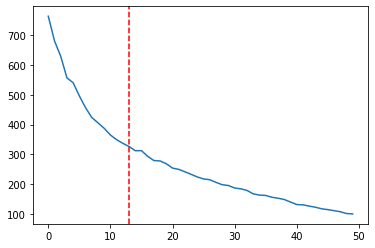

In [17]:
plt.plot(sse) # guardando l'inerzia all'aumentare del numero di cluster non sembra esserci un chiaro punto in cui l'inerzia decresce molto meno che linearmente, usero' k=13 che in diversi run e' risultato essere un buon compromesso
plt.axvline(x=13, ymin=0, ymax=700, color = 'red', linestyle='dashed')

In [18]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 20

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(components_20_noscore)
  labels = kmeans.labels_
  sil.append(silhouette_score(components_20_noscore, labels, metric = 'euclidean'))

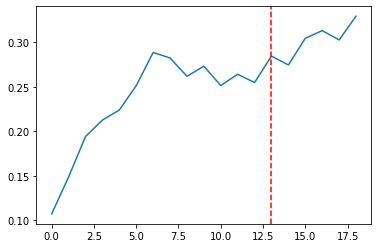

In [19]:
plt.plot(sil) #guardo il silhouette score al variare del numero di cluster per vere se questa conferma la credibilita' di 13 come numero di cluster rispetto agli altri
plt.axvline(x=13, ymin=0, ymax=700, color = 'red', linestyle='dashed') 

In [39]:
kmeans = KMeans(n_clusters = 13).fit(components_20_noscore)


In [41]:
labels_km = kmeans.labels_
unique, counts = np.unique(labels_km, return_counts=True)
dict(zip(unique,counts)) # divido gli studenti nei 13 cluster, sembra esserci qualche cluster piu' grande degli altri ma tutto sommato sembrano distribuiti in maniera sufficientemente equa

{0: 22,
 1: 44,
 2: 15,
 3: 27,
 4: 52,
 5: 40,
 6: 30,
 7: 40,
 8: 32,
 9: 22,
 10: 24,
 11: 13,
 12: 23}

In [42]:
# qui l'idea e' dividere i diversi cluster in quantili rispetto allo score ottenuto da ciascuno studente. 
# si noti che i cluster sono fatti utilizzando solo le 20 coomponenti principali ottenute proiettando il background degli studenti.
# questo dovrebbe garantire che i diversi cluster rappresentino diversi background. Andando a raggruppare gli studenti provenienti da diversi cluster
# ma appartenenti allo stesso decile mettiamo assieme gli studenti di spicco rispetto al proprio cluster mantenendo pero' variabilita'
# rispetto al background

score_cluster = pd.DataFrame(components_20_noscore)
score_cluster['score'] = students['score']
score_cluster['cluster'] = labels_km

t_test_list = []
for num_class in range(2,11):
    l1=list((np.arange(num_class)+1)/num_class)
    l1.insert(0,0)
    l2=list(np.arange(num_class)+1)
    list_quantiles = []

    for clus_id in range(13):
        quantiles = pd.qcut(score_cluster[score_cluster.cluster==clus_id].score.rank(method='first'), l1, labels=l2)
        list_quantiles.append(quantiles)
    score_cluster['class'] = pd.concat(list_quantiles)

    mean_df = score_cluster.groupby(['class']).mean().iloc[:,:20]
    std_df = score_cluster.groupby(['class']).std().iloc[:,:20]
    n_df = (score_cluster.groupby(['class']).count()).iloc[:,:20]
    SE_df = std_df/np.sqrt(n_df)
    t_test_df = (mean_df/SE_df).iloc[:,:20]
    print(np.abs(t_test_df).sum().sum()/num_class,((np.abs(t_test_df)>1.96).sum().sum()) )
    t_test_list.append(np.abs(t_test_df).sum().sum()/num_class)
num_class_sel = t_test_list.index(min(t_test_list))+2

17.192279687410853 1
17.102085186110454 7
14.786415077083157 4
15.152342146333584 7
15.16313173418321 9
15.190119887062298 9
14.92333381451116 8
15.664021081906007 11
15.580008324933265 12


In [43]:
# come richiesto il numero di classi sara' quello che garantisce sufficiente variabilita' nel background ma precisione nella divisione
# su base skill. Come implementato sotto si potrebbe selezionare il numero di classi in base alla variabilita' massima, 
# o si potrebbe selezionare il numero in base al rapporto variabilita_skill/variabilita_backgroud per prendere il rapporto piu' conveniente.
# in generale pero', viste le premesse riguardo alle lamentele rispetto alla divisione per skill un approccio piu' conservativo potrebbe essere utile.
# seleziono quindi il numero di classi prendendo il minimo della somma del t-value (in assoluto) medio sulle componenti principali.
# questo per cercare di garantire la creazione di classi con minor differenza possibile rispetto alla popolazione di partenza (che essendo PCA ha media 0)


In [44]:
for num_class in range(2,11):
    l1=list((np.arange(num_class)+1)/num_class)
    l1.insert(0,0)
    l2=list(np.arange(num_class)+1)
    list_quantiles = []

    for clus_id in range(13):
        quantiles = pd.qcut(score_cluster[score_cluster.cluster==clus_id].score.rank(method='first'), l1, labels=l2)
        list_quantiles.append(quantiles)
    score_cluster['class'] = pd.concat(list_quantiles)

    mean_df = score_cluster.groupby(['class']).mean().iloc[:,:20]
    std_df = score_cluster.groupby(['class']).std().iloc[:,:20]
    n_df = (score_cluster.groupby(['class']).count()).iloc[:,:20]
    SE_df = std_df/np.sqrt(n_df)
    t_test_df = (mean_df/SE_df)
    print(np.abs(std_df).sum().sum()/num_class,((np.abs(t_test_df)>1.96).sum().sum()))

5.987840842718543 1
5.968661580224826 7
5.970983593048179 4
5.962012471238845 7
5.959891149360743 9
5.937161088338398 9
5.947576132647374 8
5.92082794592895 11
5.922702642858947 12


In [45]:
l1=list((np.arange(num_class_sel)+1)/num_class_sel)
l1.insert(0,0)
l2=list(np.arange(num_class_sel)+1)
list_quantiles = []

for clus_id in range(13):
    quantiles = pd.qcut(score_cluster[score_cluster.cluster==clus_id].score.rank(method='first'), l1, labels=l2)
    list_quantiles.append(quantiles)
score_cluster['class'] = pd.concat(list_quantiles)

In [46]:
score_cluster.groupby(['class'])['score'].mean() #punteggio medio per classe 

class
1    0.127249
2    0.315596
3    0.497536
4    0.814134
Name: score, dtype: float64

In [47]:
score_cluster.groupby(['class'])['score'].count() #numerosita' classi

class
1    99
2    95
3    92
4    98
Name: score, dtype: int64

In [37]:
##### correlazione 

In [48]:
# qui per prima cosa testo la correlazione lineare tra le variabili relative al background e lo score ottenuto nello skill test

from scipy.stats import pearsonr

pos_corr = []
neg_corr = []
for i in range(students.shape[1]):
    corr, _ = pearsonr(students.iloc[:,i],students.score)
    if corr<-0.5:
        neg_corr.append(i)
    elif corr>0.5:
        pos_corr.append(i)


/Users/gmisser/Library/Python/3.8/lib/python/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [49]:
pos_corr,neg_corr #solamente la risposta alla 357 domanda sul background e' significativamente correlata allo score ottenuto

([357], [])

In [78]:
# visto che non sembrano esserci forti correlazioni lineari cerco correlazione tra background e score con un modello in grado di cogliere eventuali 
# correlazioni non lineari. In questo caso uso il random forest per poter applicare Boruta come metodo di feature selection, per selezionare le componenti principali piu'
# importanti nella previsione ed eventualmente avere poi un set di features su cui concentrarsi in eventuali studi futuri
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(students.iloc[:,:-1],students.iloc[:,-1],test_size=0.15)

In [79]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


rf = RandomForestRegressor(max_depth=6, min_samples_split=4)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

mean_pred = np.repeat(y_test.mean(),y_test.shape[0])
mean_squared_error(y_test, pred_rf)/mean_squared_error(y_test, mean_pred) 
# sembra possibile migliorare la previsione rispetto al semplice previsione = media dello score. Questo suggerisce la presenza di qualche relazione tra background e score.
#seppure quindi non ci siano chiare correlazioni lineari qualche lieve forma di correlazione sembra esserci.
# in media il modello sembra prevedere attorno al 15% meglio della previsione media, quindi non una grande performance ma sembra esserci spazio per eventuali investigazioni future.


0.8399114837214295

In [80]:
# uso la selezione feature Boruta per avere un set ristretto di features su cui concentrare l'eventuale futura analisi

from boruta import BorutaPy
rf_boruta = RandomForestRegressor(max_depth=6, min_samples_split=4)

feat_selector = BorutaPy(
    verbose=2,
    estimator=rf_boruta,
    n_estimators='auto',
    max_iter=10  # number of iterations to perform
)

feat_selector.fit(np.array(X_train), np.array(y_train))

support_boruta = list(feat_selector.support_weak_+feat_selector.support_) 

Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	357
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	357
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	357
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	357
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	357
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
Tentative: 	357
Rejected: 	0
Iteration: 	7 / 10
Confirmed: 	0
Tentative: 	357
Rejected: 	0
Iteration: 	8 / 10
Confirmed: 	0
Tentative: 	11
Rejected: 	346
Iteration: 	9 / 10
Confirmed: 	3
Tentative: 	8
Rejected: 	346


BorutaPy finished running.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	4
Rejected: 	346


In [81]:
np.array(range(students.iloc[:,:-1].shape[1]))[support_boruta] # lista domande possibilmente relazionate allo score nello skill test

array([101, 103, 107, 114, 197, 270, 273])